In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
# import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [4]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# lmc
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-100.0)&(lmc['LOGG']>=0.0)&
                (lmc['M_H_ERR']>-100.0)&(lmc['C_FE']>-100.0)&(lmc['N_FE']>-100.0))
lmc = lmc[cln]

# APOKASC
# kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

# Diane Feuillet
pdfout = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/LMC_DR16_all_PDF.fits.gz', 1)
_, lmc_ind, pdfout_ind = np.intersect1d(lmc['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

(array([556., 931., 493., 323., 231.,  39.,  10.,   3.,   1.,   1.]),
 array([3.5826117e-05, 2.9851755e-01, 5.9699929e-01, 8.9548099e-01,
        1.1939627e+00, 1.4924444e+00, 1.7909261e+00, 2.0894079e+00,
        2.3878896e+00, 2.6863713e+00, 2.9848530e+00], dtype=float32),
 <BarContainer object of 10 artists>)

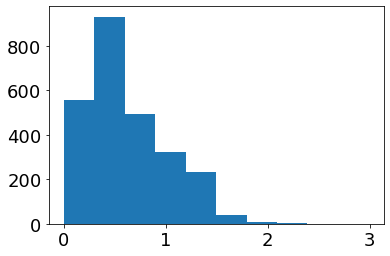

In [6]:
plt.hist(lmc['LOGG'])

In [7]:
lowgrav = parsec[np.where(parsec['logg']<=1.5)]

In [8]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

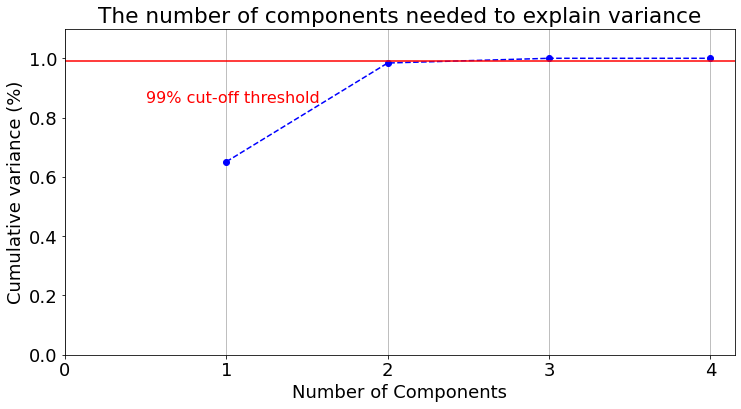

In [9]:
### Setup 
data = np.array([lowgrav['logTe'],lowgrav['Ksmag'],lowgrav['MH'],lowgrav['logg']]).T

### Determine Number of factors
pca = PCA(n_components=4).fit(data)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [10]:
### Find all models

#transform data to new basis
new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables

# linear terms
x1 = new_data[:,0]
x2 = new_data[:,1]
x3 = new_data[:,2]

# linear int
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)

# squares
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2

# cubes
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3


#find all possible models
models = []
models_str = []

all_var_str = ['x1','x2','x3','x12','x13','x23','x1sq','x2sq','x3sq','x1cu','x2cu','x3cu']
all_var = [x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
resids = []
predict = []
ll = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(lowgrav['logAge'],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - lowgrav['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))
    ll.append(model.llf)

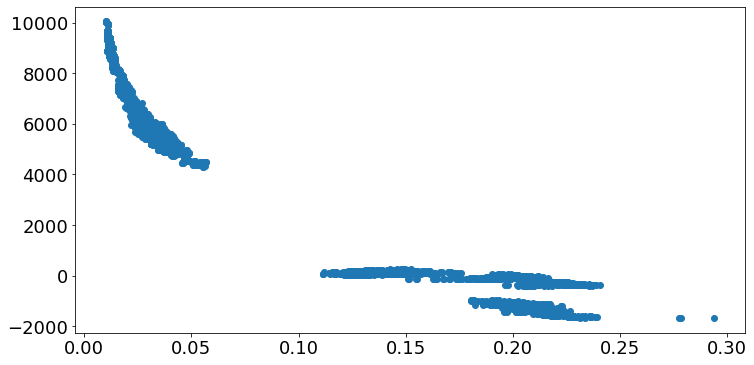

In [11]:
plt.scatter(mads,ll)

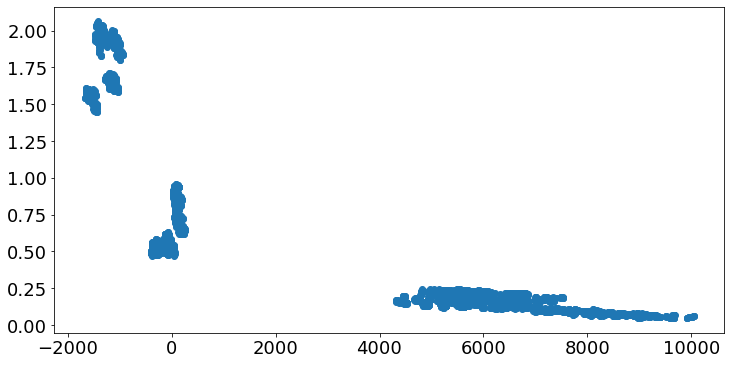

In [12]:
plt.scatter(ll,max_resid)

In [17]:
print(r'MAD')
print(models_str[np.asarray(mads).argmin()])
print(all_params[np.asarray(mads).argmin()])
print(r'LL')
print(models_str[np.asarray(ll).argmax()])
print(all_params[np.asarray(ll).argmax()])
print(r'max resid')
print(models_str[np.asarray(max_resid).argmin()])
print(all_params[np.asarray(max_resid).argmin()])
print(r'Current')
print('''['x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x2cu' 'x3cu']''')


MAD
['x1' 'x2' 'x3' 'x12' 'x13' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu']
[ 9.62380331e+00 -4.37017699e-02 -8.10474922e-02 -3.01927839e+00
  3.66311343e-02  1.13899497e-01 -9.24659108e-03  2.08472233e-02
  6.99173508e-01  3.40709987e-03  2.41138017e-03]
LL
['x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu'
 'x3cu']
[ 9.62345764e+00 -4.30768983e-02 -8.06826028e-02 -3.01563712e+00
  3.65508436e-02  1.17097905e-01 -2.59253472e-02 -8.98018594e-03
  2.10598963e-02  7.16404583e-01  3.32627539e-03  1.34864314e-03
 -3.07136600e-02]
max resid
['x1' 'x2' 'x3' 'x12' 'x13' 'x1sq' 'x2sq' 'x3cu']
[ 9.62671618e+00 -3.76516348e-02 -7.73334895e-02 -3.03980891e+00
  3.45423253e-02  8.77085003e-02 -6.14819060e-03  2.43493988e-02
  1.29436784e+00]
Current
['x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x2cu' 'x3cu']


In [49]:
parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(lowgrav['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - lowgrav['logAge']
print(afunc.mad(parsimonious_residual))
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

0.010950440970662001
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.642e+05
Date:                Tue, 19 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:40:47   Log-Likelihood:                 9946.7
No. Observations:                3446   AIC:                        -1.987e+04
Df Residuals:                    3434   BIC:                        -1.980e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6216      0.00

In [60]:
def mad_age(x1,x2,x3):
    #'x1' 'x2' 'x3' 'x12' 'x13' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu'
    p = [9.62380331e+00,-4.37017699e-02,-8.10474922e-02,-3.01927839e+00,3.66311343e-02,1.13899497e-01,
         -9.24659108e-03,2.08472233e-02,6.99173508e-01,3.40709987e-03,2.41138017e-03]
    age = (p[0]+
           p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+
           p[6]*(x1**2)+p[7]*(x2**2)+p[8]*(x3**2)+
           p[9]*(x1**3)+p[10]*(x2**3))
    return age

def ll_age(x1,x2,x3):
    #'x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu' 'x3cu'
    p = [9.62345764e+00,-4.30768983e-02,-8.06826028e-02,-3.01563712e+00,3.65508436e-02,1.17097905e-01,
         -2.59253472e-02,-8.98018594e-03,2.10598963e-02,7.16404583e-01,3.32627539e-03,1.34864314e-03,
         -3.07136600e-02]
    age = (p[0]+
           p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+p[6]*np.multiply(x2,x3)+
           p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2)+
           p[10]*(x1**3)+p[11]*(x2**3)+p[12]*(x3**3))
    return age

def max_resid_age(x1,x2,x3):
    #'x1' 'x2' 'x3' 'x12' 'x13' 'x1sq' 'x2sq' 'x3cu'
    p = [9.62671618e+00,-3.76516348e-02,-7.73334895e-02,-3.03980891e+00,3.45423253e-02,8.77085003e-02,
         -6.14819060e-03,2.43493988e-02,1.29436784e+00]
    age = (p[0]+
           p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+
           p[6]*(x1**2)+p[7]*(x2**2)+
           p[8]*(x3**3))
    return age

def current_age(x1,x2,x3):
    #'x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x2cu' 'x3cu'
    p = [9.62160564e+00,-3.73279863e-02,-8.03408138e-02,-3.01132874e+00,3.47946523e-02,1.07568186e-01,
         -2.82038911e-02,-6.71667916e-03,2.32342481e-02,7.17749242e-01,5.41993609e-04,-3.22534784e-02]
    age = (p[0]+
           p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+p[6]*np.multiply(x2,x3)+
           p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2)+
           p[10]*(x2**3)+p[11]*(x3**3))
    return age

In [51]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [89]:
mad_age_dist = []
ll_age_dist = []
max_resid_age_dist = []
current_age_dist = []

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(lmc)),desc='Done?'):
    # temperature
    teff = lmc['TEFF'][i]
    teff_err = lmc['TEFF_ERR'][i]
    
    # photometry 
    ra = lmc['RA'][i]
    dec = lmc['DEC'][i]
    ks = lmc['K'][i]
    ks_err = lmc['K_ERR'][i]
    ak = lmc['AK_TARG'][i]
    
    # abundances
    mh = lmc['M_H'][i]
    mh_err = lmc['M_H_ERR'][i]
    cfe = lmc['C_FE'][i]
    cfe_err = lmc['C_FE_ERR'][i]
    nfe = lmc['N_FE'][i]
    nfe_err = lmc['N_FE_ERR'][i]
    feh = lmc['FE_H'][i]
    feh_err = lmc['FE_H_ERR'][i]
    aM = lmc['ALPHA_M'][i]
    aM_err = lmc['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = lmc['LOGG'][i]
    lgg_err = lmc['LOGG_ERR'][i]
    
    noise_mad_ages = []
    noise_ll_ages = []
    noise_max_resid_ages = []
    noise_current_ages = []
    
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err)
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        aM_new = add_noise(aM,aM_err)
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,aM_new),lgg_new]))
        
    xs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(xs)):
        noise_mad_ages.append(mad_age(xs[l][0],xs[l][1],xs[l][2]))
        noise_ll_ages.append(ll_age(xs[l][0],xs[l][1],xs[l][2]))
        noise_max_resid_ages.append(max_resid_age(xs[l][0],xs[l][1],xs[l][2]))
        noise_current_ages.append(current_age(xs[l][0],xs[l][1],xs[l][2]))
        
    mad_age_dist.append(noise_mad_ages)
    ll_age_dist.append(noise_ll_ages)
    max_resid_age_dist.append(noise_max_resid_ages)
    current_age_dist.append(noise_current_ages)

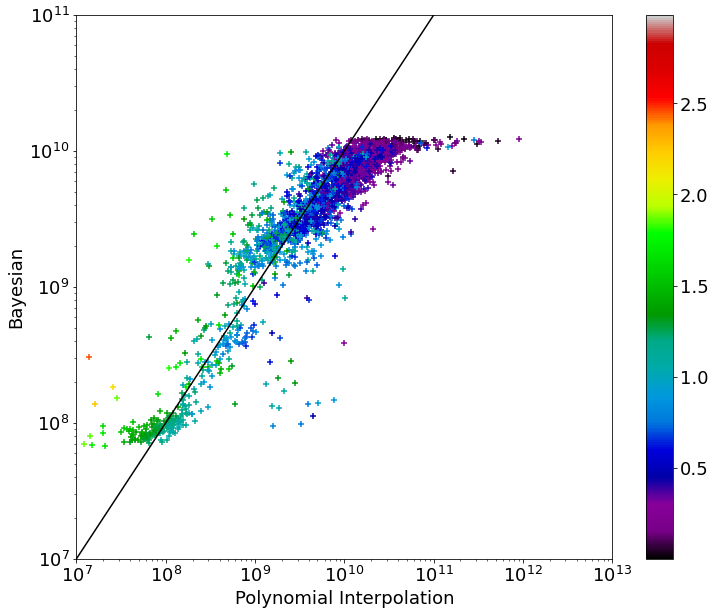

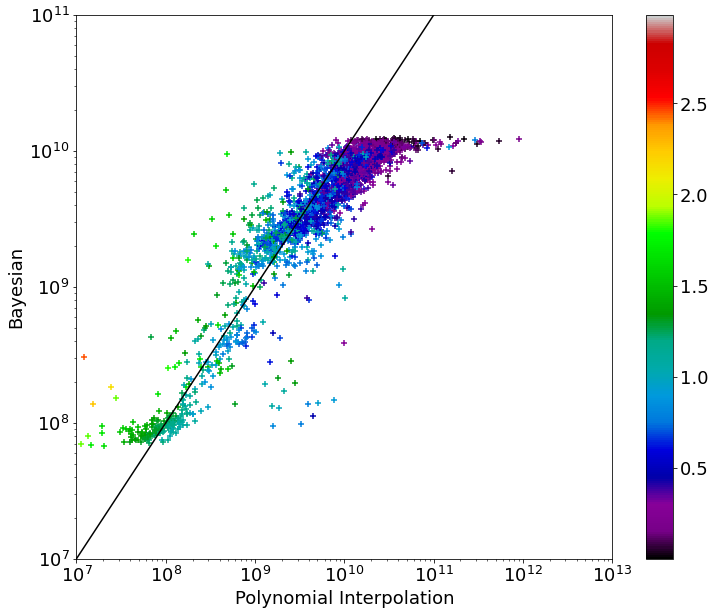

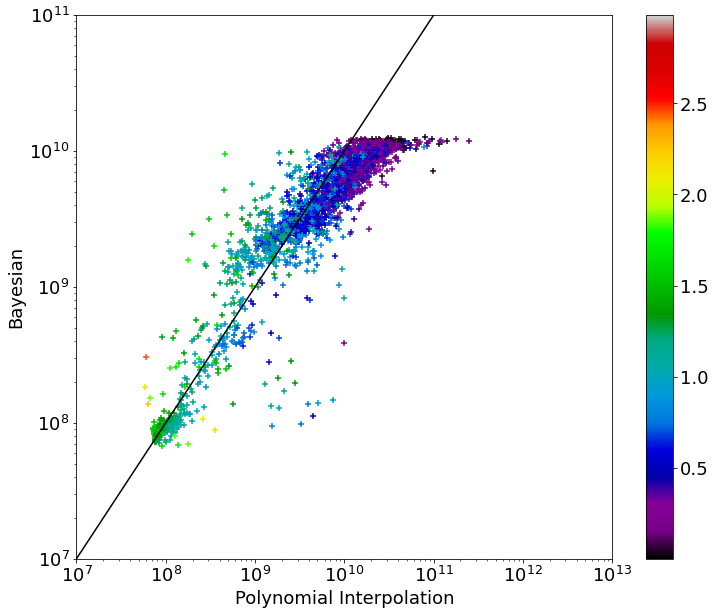

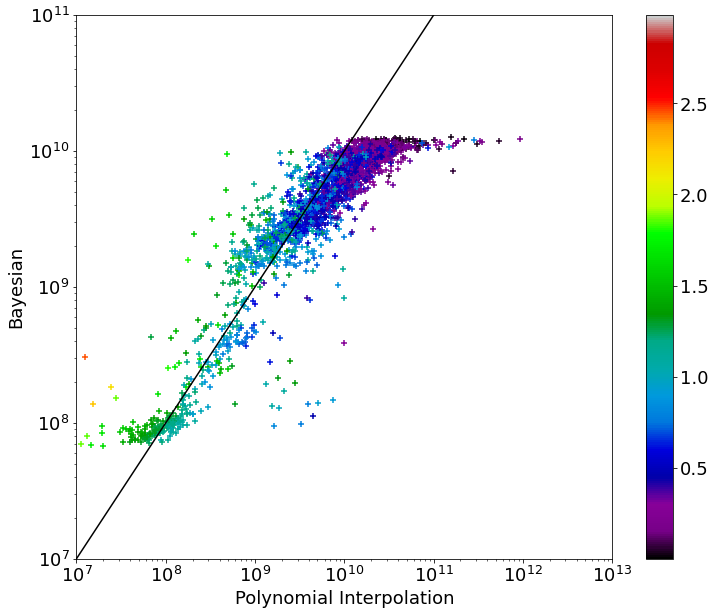

In [90]:
mad_parages = [] 
ll_parages = []
max_resid_parages = []
current_parages = []

mad_devs = []
ll_devs = []
max_resid_devs = []
current_devs = []

for k in tqdm_notebook(range(len(mad_age_dist))):
    mad_devs.append(afunc.mad(mad_age_dist[k]))
    mad_parages.append(np.median(mad_age_dist[k]))
    
    ll_devs.append(afunc.mad(ll_age_dist[k]))
    ll_parages.append(np.median(ll_age_dist[k]))
    
    max_resid_devs.append(afunc.mad(max_resid_age_dist[k]))
    max_resid_parages.append(np.median(max_resid_age_dist[k]))
    
    current_devs.append(afunc.mad(current_age_dist[k]))
    current_parages.append(np.median(current_age_dist[k]))

### MAD
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(mad_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

## #ll
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(ll_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

### max_resid
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(max_resid_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

### current
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(current_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

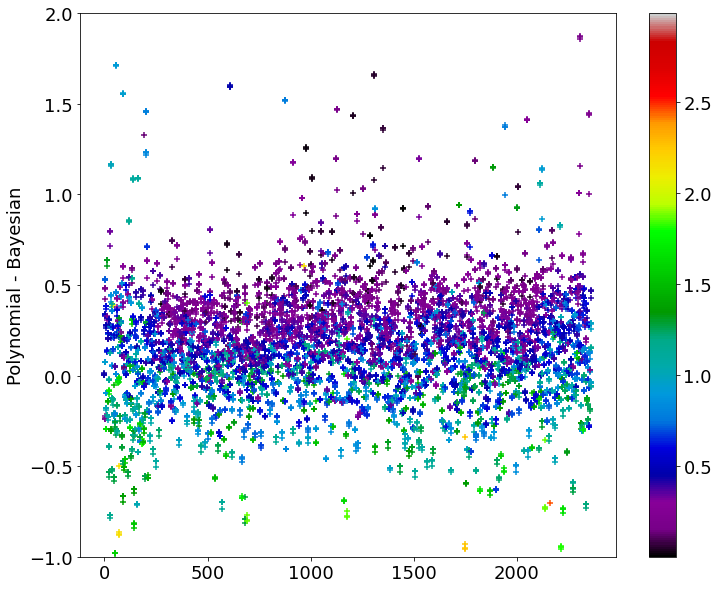

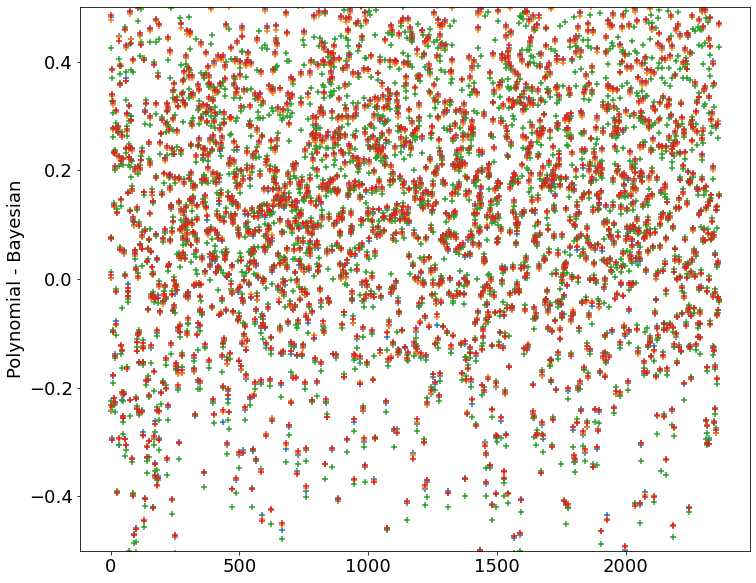

0.14662539532540464
0.1466810684828488
0.14516243792089867
0.1499203100636919


In [91]:
plt.figure(figsize=[12,10])
plt.scatter(range(len(np.asarray(mad_parages)[r13_ind])),
            np.asarray(mad_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')
plt.scatter(range(len(np.asarray(ll_parages)[r13_ind])),
            np.asarray(ll_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')
plt.scatter(range(len(np.asarray(max_resid_parages)[r13_ind])),
            np.asarray(max_resid_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')
plt.scatter(range(len(np.asarray(current_parages)[r13_ind])),
            np.asarray(current_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')

plt.colorbar()

plt.ylim(-1,2)

plt.ylabel(r'Polynomial - Bayesian')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(range(len(np.asarray(mad_parages)[r13_ind])),
            np.asarray(mad_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind],
            marker='+',c='tab:blue')
plt.scatter(range(len(np.asarray(ll_parages)[r13_ind])),
            np.asarray(ll_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind],
            marker='+',c='tab:orange')
plt.scatter(range(len(np.asarray(max_resid_parages)[r13_ind])),
            np.asarray(max_resid_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind],
            marker='+',c='tab:green')
plt.scatter(range(len(np.asarray(current_parages)[r13_ind])),
            np.asarray(current_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind],
            marker='+',c='tab:red')

plt.ylim(-0.5,0.5)

plt.ylabel(r'Polynomial - Bayesian')
plt.show()

print(np.median(np.asarray(mad_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]))
print(np.median(np.asarray(ll_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]))
print(np.median(np.asarray(max_resid_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]))
print(np.median(np.asarray(current_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]))

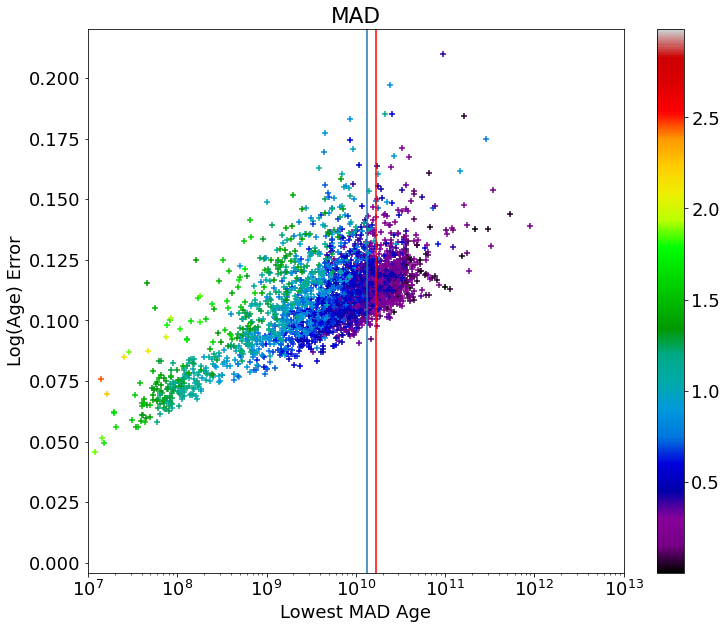

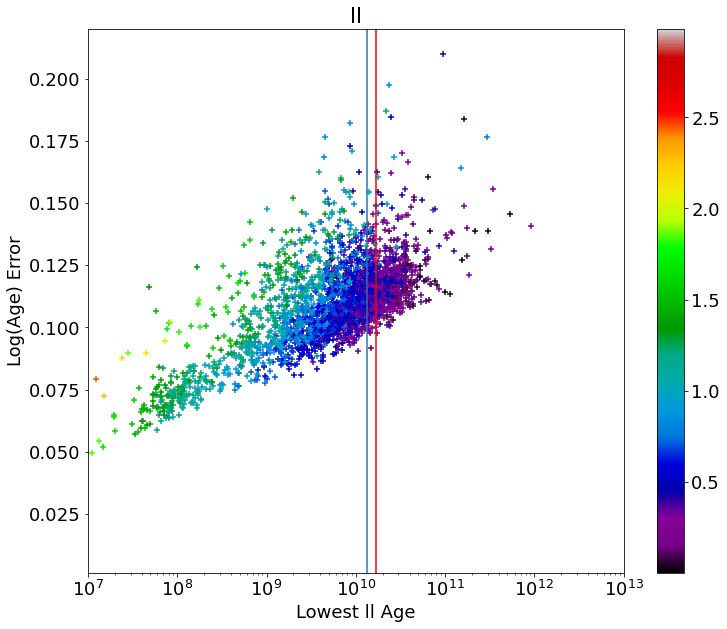

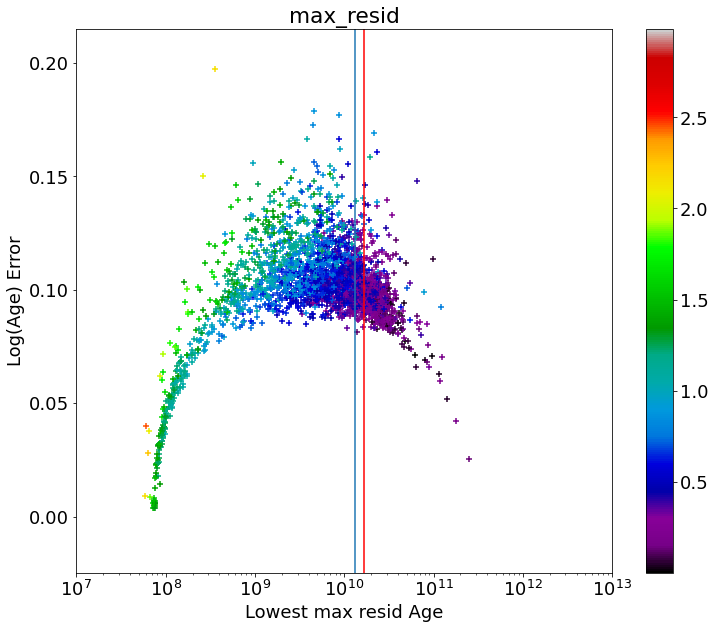

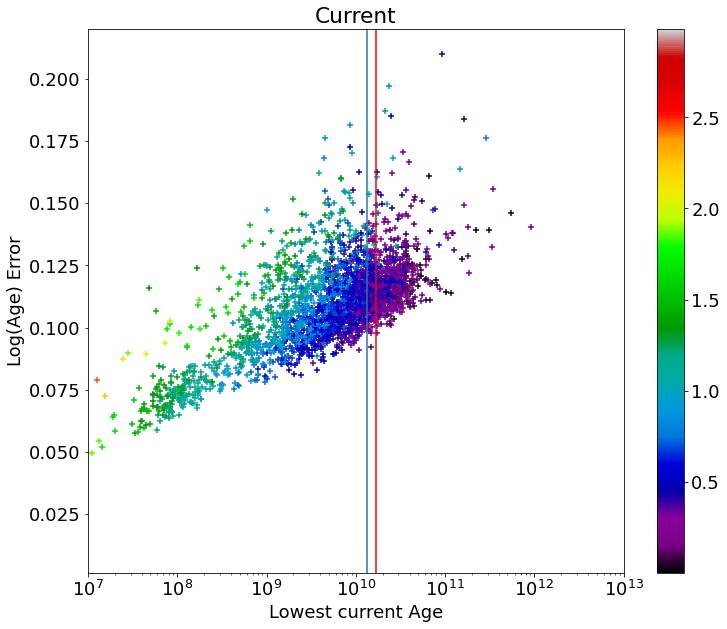

In [110]:
### MAD
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(mad_parages),mad_devs,c=lmc['LOGG'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(mad_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'MAD; Color as LOGG')
plt.xlabel(r'Lowest MAD Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### ll
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(ll_parages),ll_devs,c=lmc['LOGG'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(ll_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'll; Color as LOGG')
plt.xlabel(r'Lowest ll Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### max_resid
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(max_resid_parages),max_resid_devs,c=lmc['LOGG'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(max_resid_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.ylim(top=0.215)

plt.title(r'max_resid; Color as LOGG')
plt.xlabel(r'Lowest max resid Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### current
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(current_parages),current_devs,c=lmc['LOGG'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(current_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'Current; Color as LOGG')
plt.xlabel(r'Lowest current Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

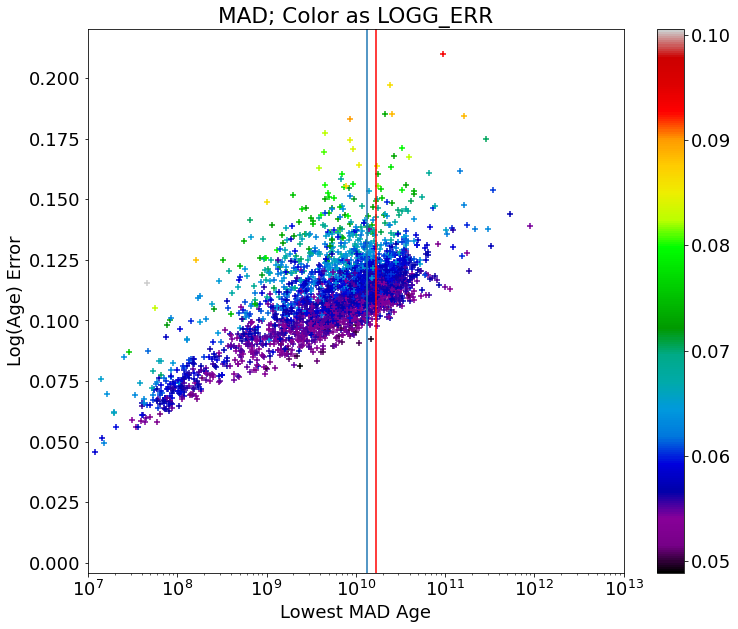

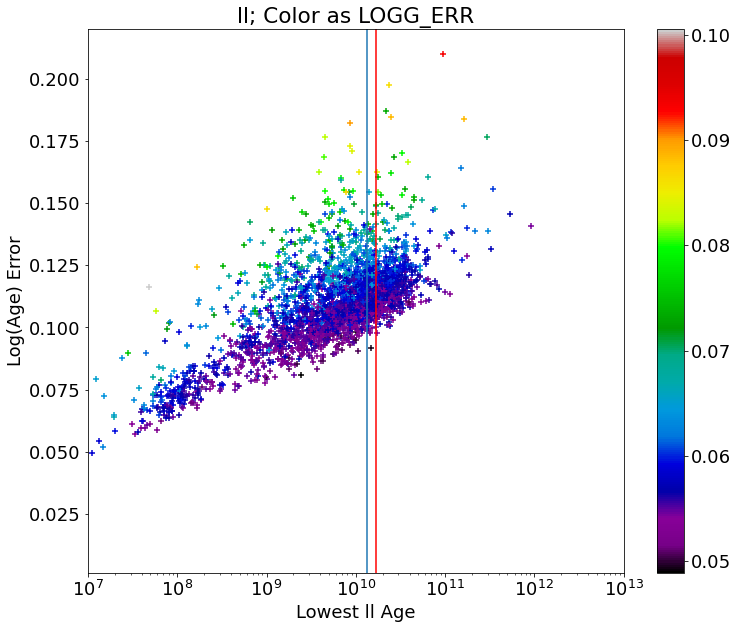

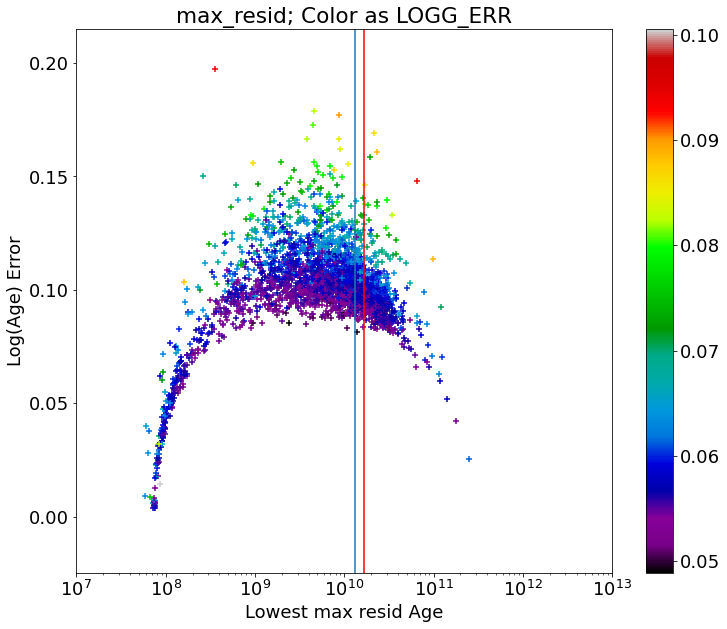

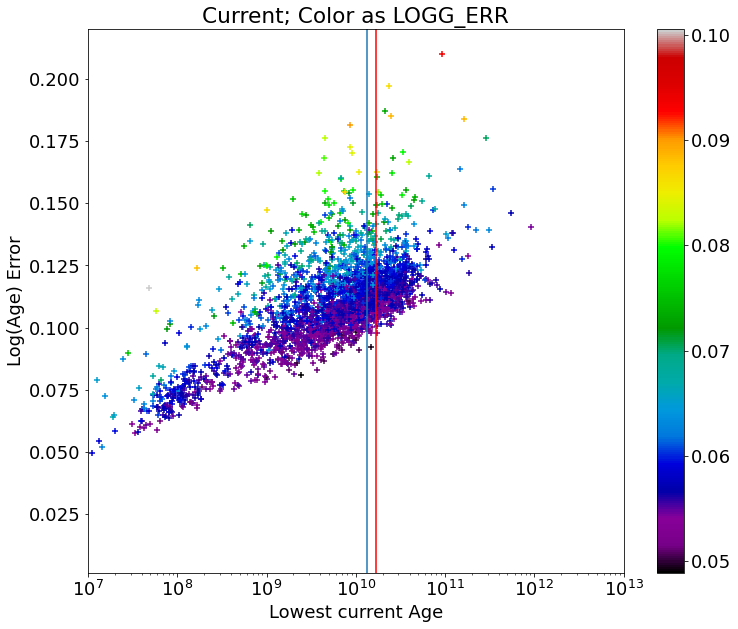

In [113]:
### MAD
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(mad_parages),mad_devs,c=lmc['LOGG_ERR'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(mad_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'MAD; Color as LOGG_ERR')
plt.xlabel(r'Lowest MAD Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### ll
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(ll_parages),ll_devs,c=lmc['LOGG_ERR'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(ll_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'll; Color as LOGG_ERR')
plt.xlabel(r'Lowest ll Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### max_resid
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(max_resid_parages),max_resid_devs,c=lmc['LOGG_ERR'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(max_resid_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.ylim(top=0.215)

plt.title(r'max_resid; Color as LOGG_ERR')
plt.xlabel(r'Lowest max resid Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### current
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(current_parages),current_devs,c=lmc['LOGG_ERR'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(current_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'Current; Color as LOGG_ERR')
plt.xlabel(r'Lowest current Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

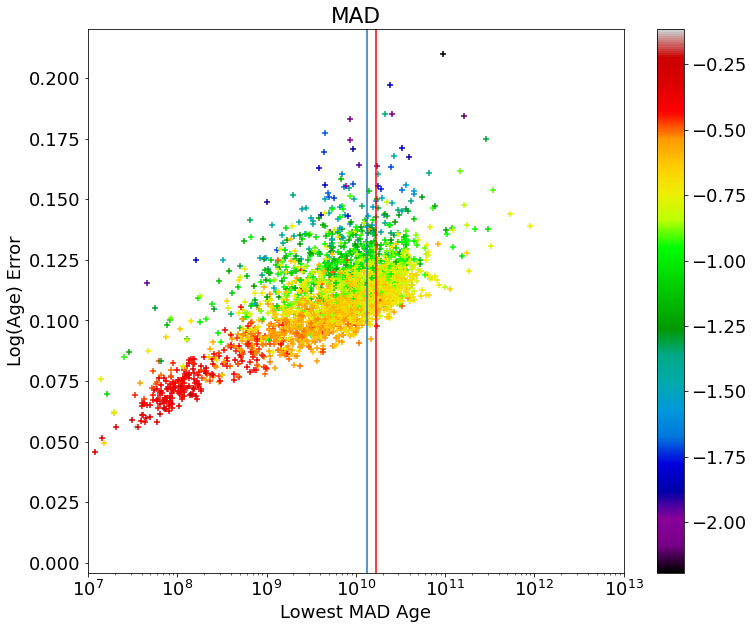

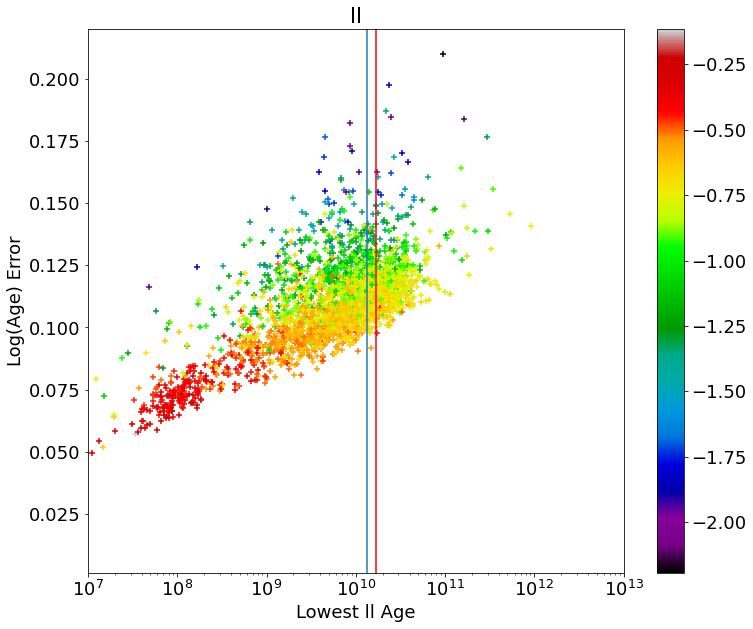

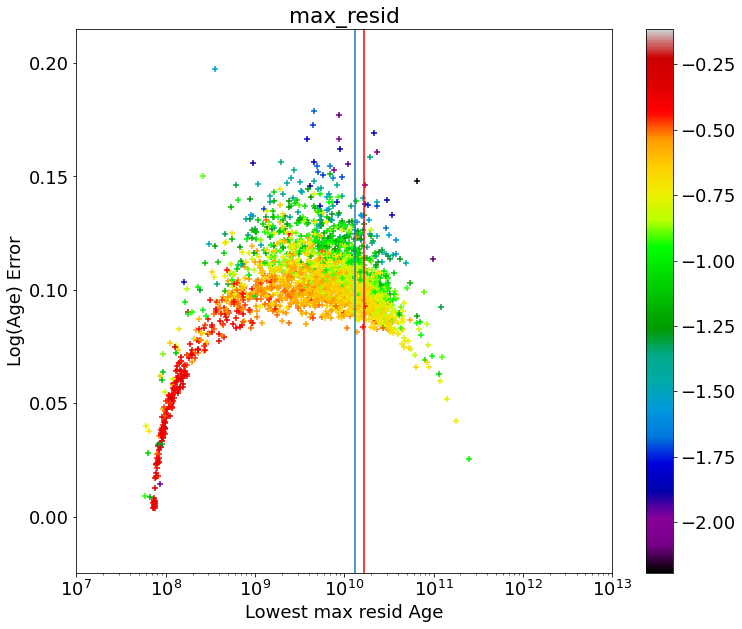

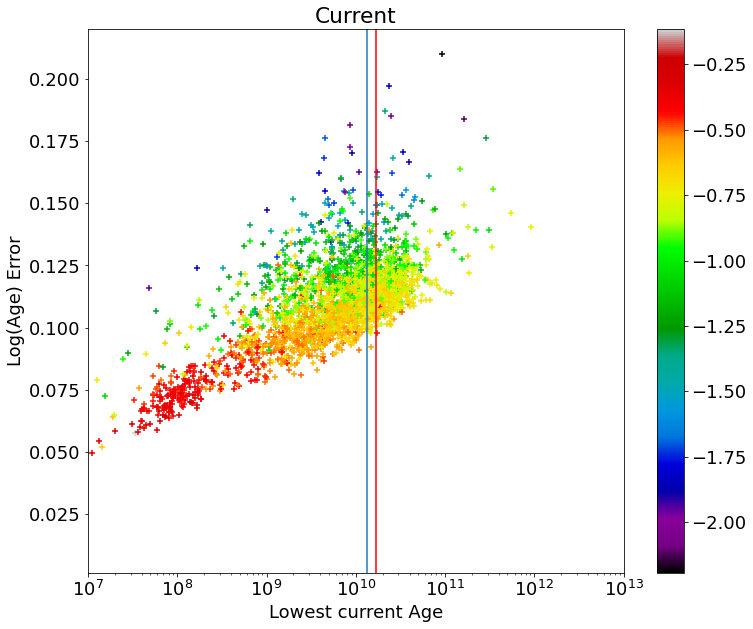

In [111]:
### MAD
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(mad_parages),mad_devs,c=lmc['FE_H'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(mad_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'MAD; Color as FE_H')
plt.xlabel(r'Lowest MAD Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### ll
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(ll_parages),ll_devs,c=lmc['FE_H'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(ll_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'll; Color as FE_H')
plt.xlabel(r'Lowest ll Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### max_resid
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(max_resid_parages),max_resid_devs,c=lmc['FE_H'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(max_resid_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.ylim(top=0.215)

plt.title(r'max_resid; Color as FE_H')
plt.xlabel(r'Lowest max resid Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### current
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(current_parages),current_devs,c=lmc['FE_H'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(current_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'Current; Color as FE_H')
plt.xlabel(r'Lowest current Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

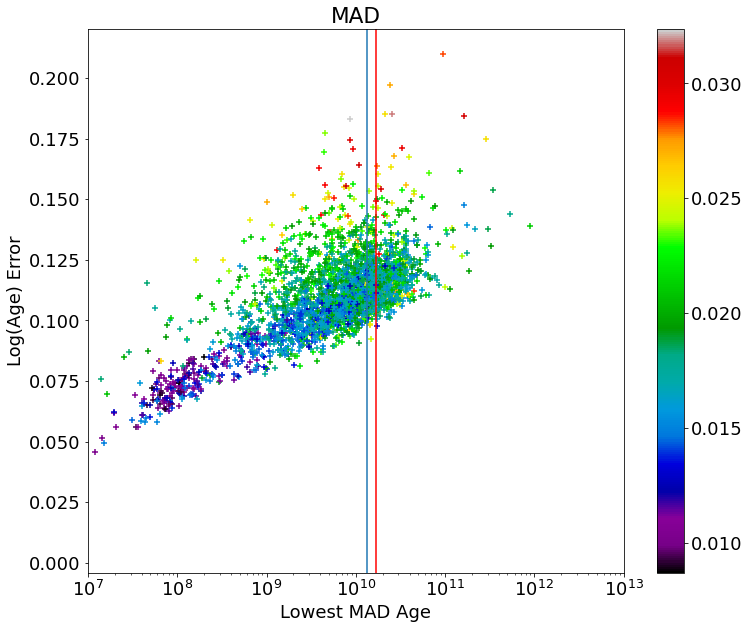

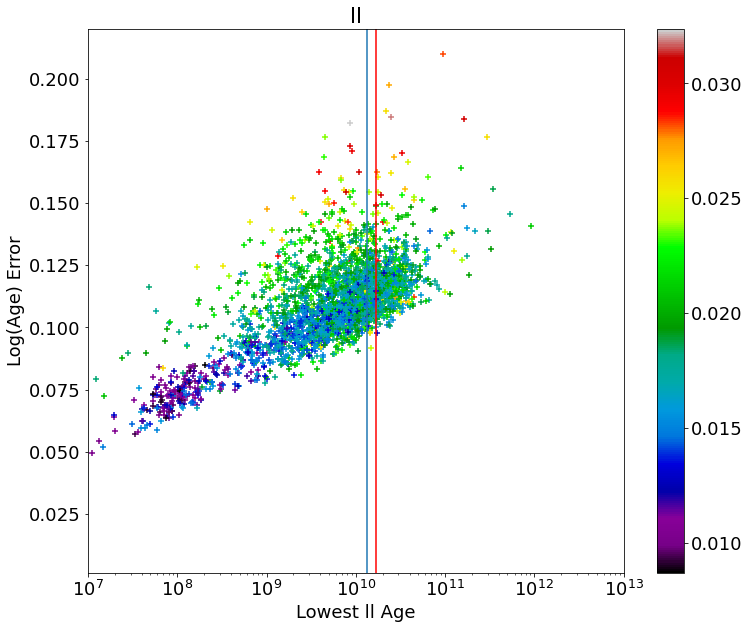

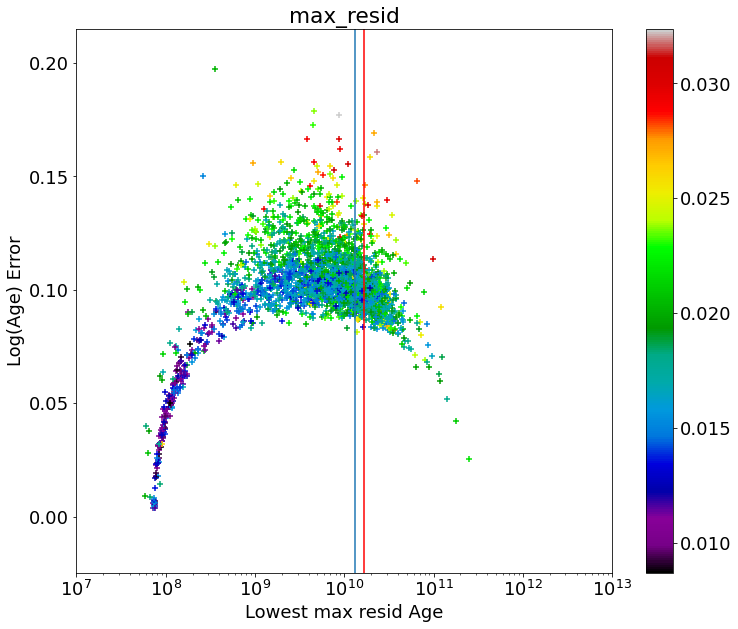

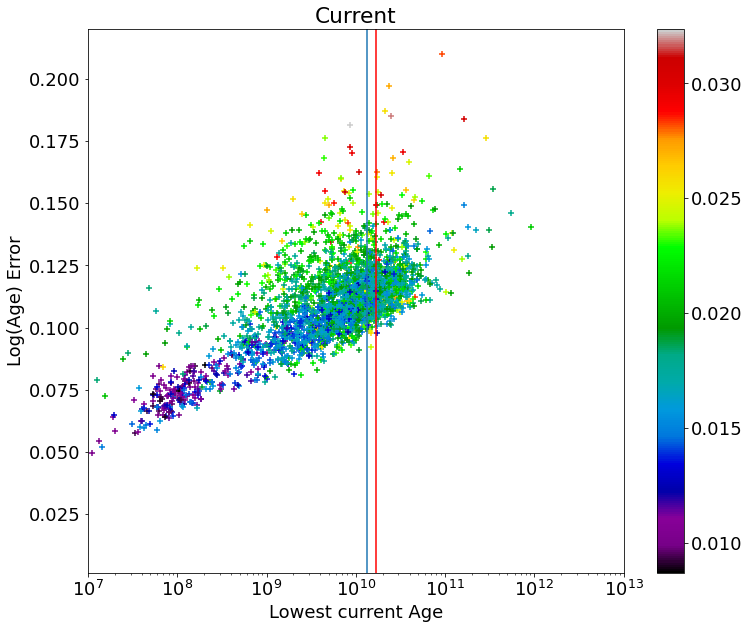

In [112]:
### MAD
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(mad_parages),mad_devs,c=lmc['FE_H_ERR'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(mad_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'MAD; Color as FE_H_ERR')
plt.xlabel(r'Lowest MAD Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### ll
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(ll_parages),ll_devs,c=lmc['FE_H_ERR'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(ll_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'll; Color as FE_H_ERR')
plt.xlabel(r'Lowest ll Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### max_resid
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(max_resid_parages),max_resid_devs,c=lmc['FE_H_ERR'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(max_resid_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.ylim(top=0.215)

plt.title(r'max_resid; Color as FE_H_ERR')
plt.xlabel(r'Lowest max resid Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

### current
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(current_parages),current_devs,c=lmc['FE_H_ERR'],marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.axvline(ageU)
plt.axvline(10**(np.log10(ageU)+np.median(current_devs)),c='r')

plt.xscale('log')
plt.xlim(10**7,10**13)

plt.title(r'Current; Color as FE_H_ERR')
plt.xlabel(r'Lowest current Age')
plt.ylabel(r'Log(Age) Error')
plt.show()

In [ ]:
######################
### Residual Plots ###
######################



In [115]:

cat = Table()
col_id = Column(np.asarray(r13['APOGEE_ID']),name='APOGEE_ID')
col_mad_age = Column(np.asarray(mad_parages),name='MAD_AGE')
col_mad_dev = Column(np.asarray(mad_devs),name='MAD_AGE_ERR')
col_ll_age = Column(np.asarray(ll_parages),name='LL_AGE')
col_ll_dev = Column(np.asarray(ll_devs),name='LL_AGE_ERR')
col_max_resid_age = Column(np.asarray(max_resid_parages),name='MAX_RESID_AGE')
col_max_resid_dev = Column(np.asarray(max_resid_devs),name='MAX_RESID_AGE_ERR')
col_current_age = Column(np.asarray(current_parages),name='CURRENT_AGE')
col_current_dev = Column(np.asarray(current_devs),name='CURRENT_AGE_ERR')

cat.add_column(col_id)
cat.add_column(col_mad_age)
cat.add_column(col_mad_dev)
cat.add_column(col_ll_age)
cat.add_column(col_ll_dev)
cat.add_column(col_max_resid_age)
cat.add_column(col_max_resid_dev)
cat.add_column(col_current_age)
cat.add_column(col_current_dev)

# cat.write('pca_ols_loggs.fits',format='fits',overwrite=True)

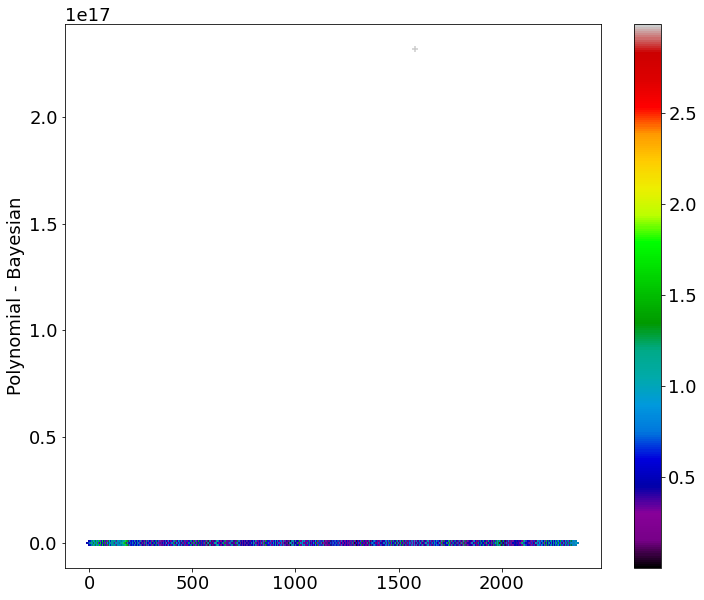

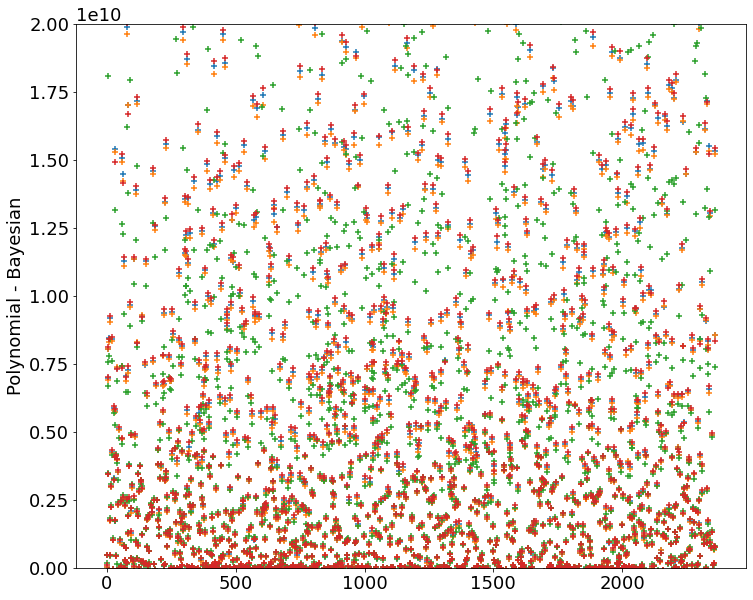

1.8176256043093242
1.800890222885066
1.8918877021355687
1.8518091325460204


In [95]:
plt.figure(figsize=[12,10])
plt.scatter(range(len(np.asarray(mad_parages)[r13_ind])),
            10**np.asarray(mad_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')
plt.scatter(range(len(np.asarray(ll_parages)[r13_ind])),
            10**np.asarray(ll_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')
plt.scatter(range(len(np.asarray(max_resid_parages)[r13_ind])),
            10**np.asarray(max_resid_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')
plt.scatter(range(len(np.asarray(current_parages)[r13_ind])),
            10**np.asarray(current_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')

plt.colorbar()

# plt.ylim(-1,2)

plt.ylabel(r'Polynomial - Bayesian')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(range(len(np.asarray(mad_parages)[r13_ind])),
            10**np.asarray(mad_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind],
            marker='+',c='tab:blue')
plt.scatter(range(len(np.asarray(ll_parages)[r13_ind])),
            10**np.asarray(ll_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind],
            marker='+',c='tab:orange')
plt.scatter(range(len(np.asarray(max_resid_parages)[r13_ind])),
            10**np.asarray(max_resid_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind],
            marker='+',c='tab:green')
plt.scatter(range(len(np.asarray(current_parages)[r13_ind])),
            10**np.asarray(current_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind],
            marker='+',c='tab:red')

plt.ylim(0,20*10**9)

plt.ylabel(r'Polynomial - Bayesian')
plt.show()

print(np.median(10**np.asarray(mad_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind])/10**9)
print(np.median(10**np.asarray(ll_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind])/10**9)
print(np.median(10**np.asarray(max_resid_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind])/10**9)
print(np.median(10**np.asarray(current_parages)[r13_ind]-10**pdfout['P_MEAN'][pdfout_ind])/10**9)